In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math
from sklearn.model_selection import KFold


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *


import scoping.utils.learning_utils as lu
import random
import scipy.stats as st


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)


now=datetime.datetime.today()

## First we say what query and project we are interested in

This is using the NACSOS platform

In [2]:
pid = 234
qid = 8318
qids = [8318, 8421, 8503]
merged_query = Query.objects.get(pk=8510)
docids = set(Doc.objects.filter(query__in=qids).values_list('id',flat=True))
docs = Doc.objects.filter(id__in=docids)
p = Project.objects.get(pk=pid)

#print(q.doc_set.count())
docs.count()

316664

### And we retrieve those documents that have been screened in that query, and get the majority rating

In [3]:
import statistics

def mode_na(x):
    try:
        return statistics.mode([y for y in x if y is not np.NaN])
    except:
        return np.NaN
    
columns = [
    'id',
    'content',
    'title',
    'PY',
    'wosarticle__de',
    'wosarticle__wc'
]

# First get only the ratings from updated tags

update_tags = Tag.objects.filter(pk__in=[5598, 5597, 5577, 5562, 5551, 5550, 5632, 5630, 5629]) 
updated_dos = DocOwnership.objects.filter(
    tag__in=update_tags, 
    relevant__gt=0,
    doc__content__iregex='\w'
)
dodf = pd.DataFrame.from_dict(updated_dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN

updated_df = gdf

ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=updated_df['id']).values(*columns)
)
updated_df = pd.merge(ddf,updated_df)

In [4]:
# Now get majority ratings from the rest of documents
# Majority ratings
dos = DocOwnership.objects.filter(
    query__in=qids, 
    relevant__gt=0,
    doc__content__iregex='\w'
).exclude(doc__id__in=updated_df["id"])
dodf = pd.DataFrame.from_dict(dos.order_by('finish').values(
    'id','doc_id','user__username','relevant'
))
dodf.loc[dodf['relevant']==2,'relevant'] = 0
dodf.loc[dodf['relevant']==3,'relevant'] = np.NaN

gdf = dodf.groupby('doc_id').agg(lambda x: mode_na(x)).reset_index()[['doc_id','relevant']].rename(columns={"doc_id":"id"})
gdf['seen'] = 1
gdf.loc[pd.isna(gdf['relevant']),'seen'] = np.NaN

seen_df = gdf
ddf = pd.DataFrame.from_dict(
    Doc.objects.filter(pk__in=seen_df['id']).values(*columns)
)
seen_df = pd.merge(ddf,seen_df)

seen_df = pd.concat([seen_df,updated_df])
print(seen_df.shape)
seen_df.head()

(3730, 8)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen
0,3444973,"Lateral transfer, vertical translocation, and ...","Lateral Transfer, Vertical Translocation, and ...",2013.0,None,[Biotechnology & Applied Microbiology; Food Sc...,0.0,1.0
1,14865,BACKGROUND: Patients with acute heat illness p...,Summertime Acute Heat Illness in U.S. Emergenc...,2014.0,None,"[Environmental Sciences; Public, Environmental...",1.0,1.0
2,282602,Background: Among the many challenges faced by...,Health coping strategies of the people vulnera...,2013.0,Health coping strategies; Choice of care; Unqu...,"[Public, Environmental & Occupational Health]",1.0,1.0
3,3446583,This study analyzes how the meaning of a city ...,An approach to semiotic discourse in creating ...,2019.0,city brand; perceptions; speech; symbols; Ecuador,[Communication],0.0,1.0
4,3496789,Background: Pancreatic cancer is the fourth le...,Nutrition and Pancreatic Cancer,2014.0,Pancreatic cancer; nutrition; diet; dietary fa...,[Oncology],0.0,1.0


In [5]:
#ADDED FOR TEST
testing=False
if testing:
    seen_df = seen_df.head(1000)
    print(seen_df.shape)

### We have a separate list of documents in the query that have not been screened

In [6]:
t0 = time.time()
#docs = Doc.objects.filter(pk__lt=1000,query=merged_query)
docs = Doc.objects.filter(id__in=docids)
unseen_docs = docs.filter(
    content__iregex='\w',
    wosarticle__dt__iregex='Article|Review'
).exclude(
    wosarticle__dt__iregex='book|proceedings|comment|retracted|editorial'
).exclude(
    id__in=seen_df['id']
)

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
print(time.time()-t0)
unseen_df.head()

(282414, 8)
65.09873032569885


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen
0,423122,This paper reviews the current literature arou...,"Are the Dietary Guidelines for Meat, Fat, Frui...",2014.0,environmental impact; diet; food; red meat; an...,[Nutrition & Dietetics],0,0
1,1828097,This study investigated the effects of feeding...,Effect of Feeding System on Enteric Methane Em...,2018.0,cattle; greenhouse gas; measurements; diet; va...,[Environmental Studies],0,0
2,3749996,Citrus × clementina juice obtained from fruits...,Investigating the in vitro hypoglycaemic and a...,2018.0,None,None,0,0
3,3474740,Ambient-cured heavyweight geopolymer concrete ...,Properties of Ambient-Cured Normal and Heavywe...,2019.0,geopolymer concrete; heavyweight geopolymer co...,"[Materials Science, Multidisciplinary]",0,0
4,3750069,The physical properties and characteristics of...,The Characteristics and Genetic Analysis of th...,2018.0,None,None,0,0


In [7]:
#ADDED FOR TEST
if testing:
    unseen_df = unseen_df.head(1000)
    print(unseen_df.shape)

### And we merge the two, with a column "seen" recording if a document has been seen or not

In [8]:
django.db.connection.close()
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)
y = df['relevant']

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

print(df.shape)
df.head(10)

(286144, 8)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen
0,3487494,"In Cotonou, as in many expanding West African ...",Degradation of groundwater quality in expandin...,2020.0,Groundwater; Sewerage and septic tank contamin...,"[Engineering, Civil; Geosciences, Multidiscipl...",0.0,0.0
1,3469235,Many shrimp farmers were suffering from White ...,Effects of temperature on hematological and hi...,2014.0,White Spot Syndrom Virus; Temperature; Fennero...,[Fisheries],0.0,0.0
2,3412530,Big data and cloud computing are two phenomena...,A Case Study of Advancing Remote Sensing Image...,2015.0,remote sensing image analysis; object based im...,"[Computer Science, Cybernetics]",0.0,0.0
3,3482141,Knowledge of the release of volatile organic c...,Quantitative analysis of volatile organic comp...,2014.0,L6 cells; skeletal muscle; volatile organic co...,[Biochemical Research Methods; Respiratory Sys...,0.0,0.0
4,3400113,"Burkholderia pseudomallei, causative agent of ...",Rivers as carriers and potential sentinels for...,2018.0,None,[Multidisciplinary Sciences],0.0,0.0
5,3407818,Food intake and circadian rhythms are regulate...,The effects of graded levels of calorie restri...,2016.0,calorie restriction; circadian rhythm; hunger;...,[Cell Biology; Geriatrics & Gerontology],0.0,0.0
6,3505798,The challenges in successful vaccination again...,Traditional and new influenza vaccines,2013.0,None,None,0.0,0.0
7,305736,Background and objective: Cold-induced airway ...,Transient receptor potential melastatin 8 gene...,2015.0,asthma; cold temperature; polymorphism; spirom...,[Respiratory System],0.0,0.0
8,3412896,"Air pollution can endanger human health, espec...",An Analysis of Factors Influencing the Relatio...,2018.0,Aerosol Optical Depth; PM10; MAIAC; MODIS; air...,[Remote Sensing],0.0,0.0
9,3494232,"With a high surface to volume ratio, small org...",Behavioral and Physiological Resistance to Des...,2019.0,water balance; Drosophila; humidity sensing; w...,[Entomology],0.0,0.0


### We also get the assignments of these documents to categories, and add these as further columns in our dataframe
again we get the majority ratings

In [9]:
# first get only those ratings from the updated tags
dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=updated_df['id'],category__project=p
    ).values('user__username','doc__id','category__level','category__name')
)
updated_docusers = updated_dos.values_list('doc__id',"user__username")
dudf = dudf[dudf[['doc__id', 'user__username']].apply(tuple, axis=1).isin(updated_docusers)]
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
updated_gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: st.mode(x)[0][0]).reset_index()


dudf = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        doc__pk__in=set(seen_df['id']) - set(updated_df['id']),category__project=p
    ).values('user__username','doc__id','category__level','category__name')
)
dudf['v'] = 1
dudf['cname'] =  dudf['category__level'].astype(str) + " - " + dudf['category__name']#
dudf = dudf.drop(columns=['category__level','category__name'])
dudf_wide = dudf.pivot_table(index=['doc__id','user__username'],columns="cname", values="v").fillna(0)
gudf = dudf_wide.groupby(['doc__id']).agg(lambda x: st.mode(x)[0][0]).reset_index()

#merge updated and old
gudf = pd.concat([gudf,updated_gudf])

print(gudf.shape)
gudf.tail()

(1038, 4)


cname,doc__id,1 - Adaptation,1 - Impact,1 - Mitigation
267,3538514,1.0,0.0,0.0
268,3540061,0.0,0.0,1.0
269,3541391,1.0,0.0,0.0
270,3545382,1.0,0.0,0.0
271,3546196,0.0,1.0,0.0


## And merge

In [10]:
df = pd.merge(df, gudf.rename(columns={"doc__id":"id"}), how="left").fillna(0)
print(df.shape)
df.head()

(286144, 11)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,1 - Adaptation,1 - Impact,1 - Mitigation
0,3487494,"In Cotonou, as in many expanding West African ...",Degradation of groundwater quality in expandin...,2020.0,Groundwater; Sewerage and septic tank contamin...,"[Engineering, Civil; Geosciences, Multidiscipl...",0.0,0.0,0.0,0.0,0.0
1,3469235,Many shrimp farmers were suffering from White ...,Effects of temperature on hematological and hi...,2014.0,White Spot Syndrom Virus; Temperature; Fennero...,[Fisheries],0.0,0.0,0.0,0.0,0.0
2,3412530,Big data and cloud computing are two phenomena...,A Case Study of Advancing Remote Sensing Image...,2015.0,remote sensing image analysis; object based im...,"[Computer Science, Cybernetics]",0.0,0.0,0.0,0.0,0.0
3,3482141,Knowledge of the release of volatile organic c...,Quantitative analysis of volatile organic comp...,2014.0,L6 cells; skeletal muscle; volatile organic co...,[Biochemical Research Methods; Respiratory Sys...,0.0,0.0,0.0,0.0,0.0
4,3400113,"Burkholderia pseudomallei, causative agent of ...",Rivers as carriers and potential sentinels for...,2018.0,0,[Multidisciplinary Sciences],0.0,0.0,0.0,0.0,0.0


### We have a look at the distribution of relevant and not relevant documents


Text(0, 0.5, 'Number of documents')

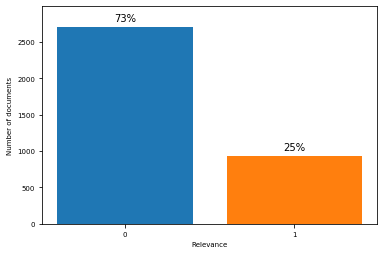

In [11]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

### Now we "vectorize" the data, representing each document as a weighted count of its words and phrases (bag of words and bigrams). Or if we already did this previously, then we reload the vectorized data

In [21]:
import pickle
import scipy
revectorize = True
y = df['relevant']
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=4, max_df=0.8, strip_accents='unicode', 
        max_features=10000,
        use_idf=1,
        smooth_idf=1, sublinear_tf=1,
        stop_words="english",tokenizer=lu.tokenize
    )
    vec.fit(df.loc[seen_index,'content'].astype(str))
    ab_X = vec.transform(df['content'].astype(str))
    with open ('vec.pickle','wb') as f: #changed dir from data/vec.pickle to just vec.pickle
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('X.npz', ab_X)
else:
    with open ('vec.pickle','rb') as f:
        vec = pickle.load(f)
    ab_X = scipy.sparse.load_npz('X.npz')#changed dir from data/vec.pickle to just vec.pickle
    
print(ab_X.shape)

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(286144, 10000)


### We build 3 types of classifiers, and test these with k-fold cross validation

In [24]:
def cross_validate_models(X,y,clf_models, seen_index, n_splits=10, classes=None,
    upsample=False,roundup=False, df=None,
    stratified_k=False, test_index=None, p_threshold=None):    
    
    if stratified_k:
        label_encoder = LabelEncoder()
        kf = StratifiedKFold(n_splits=n_splits)
        kfs = kf.split(X[seen_index],label_encoder.fit_transform(y[seen_index]))
    else:
        kf = KFold(n_splits=n_splits)
        kfs = kf.split(X[seen_index],y[seen_index])
    i=0    
    
    def tpr(y_true, y_pred):
        return roc_curve(y_true, y_pred)[1]
    def fpr(y_true, y_pred):
        return roc_curve(y_true, y_pred)[0]
    def prec(y_true, y_pred):
        return precision_recall_curve(y_true,y_pred)[0]
    def rec(y_true, y_pred):
        return precision_recall_curve(y_true,y_pred)[1]    
    
    scores = [
        # name, function, on y when multiclas, on each y when multiclass, # proba
        ('p',precision_score, True, True, False),
        ('r',recall_score, True, True, False),
        ('f1', f1_score, True, True, False),
        ('e', accuracy_score, True, True, False),
        ('i', None, False, False, False),
        ('auc', roc_auc_score, True, True, True),
        ('tpr', tpr, False, True, True),
        ('fpr', fpr, False, True, True),
        ('prec', prec, False, True, True),
        ('rec', rec, False, True, True)
    ]    
    
    if classes:
        scores += [
            ('cov_err', coverage_error, True, False, False),
            ('LRAP', label_ranking_average_precision_score, True, False, False),
            ('LRL', label_ranking_loss, True, False, False)
        ]    
        
    for model in clf_models:
        for m in scores:
            model[m[0]] = []
        metrics = ['e']
        if classes:
            for j, y_class in enumerate(classes):
                for m in scores:
                    if m[1]:
                        model[f'{m[0]}\n{y_class}'] = []                
                        
                metrics += [f'p\n{y_class}', f'r\n{y_class}']    
                
    if test_index is not None:
        test_preds = []    
    for k_train, k_test in kfs:
        k_train = seen_index[k_train]
        k_test = seen_index[k_test]
        if test_index is not None:
            k_test = test_index
        if upsample:
            ros = RandomOverSampler(random_state=42)
            if classes:
                lp = LabelPowerset()
                yt = lp.transform(y)
                X_train, y_resampled = ros.fit_resample(X[k_train],yt[k_train])
                y_train = lp.inverse_transform(y_resampled).todense()
            else:
                X_train, y_train = ros.fit_resample(X[k_train],y[k_train].todense())
        else:
            X_train = X[k_train]
            y_train = y[k_train]
        i+=1
        print(i)
        for model in clf_models:
            clf = model['model']
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(X_train,y_train)
            predictions = clf.predict(X[k_test])
            try:
                predictions_proba = clf.predict_proba(X[k_test])
            except:
                predictions_proba = predictions
                print("WARNING! Can't predict probabilities with this model, just using binary predictions")
                
            if hasattr(predictions_proba,"todense"):
                predictions_proba = predictions_proba.todense()
            if hasattr(predictions,"todense"):
                predictions = predictions.todense()
            if test_index is not None:
                test_preds.append(predictions_proba)
            if p_threshold is not None:
                predictions = np.where(predictions_proba>=p_threshold,1,0)[:,1]           
            
            if classes:
                if roundup:
                    for j, c in enumerate(predictions_proba.argmax(axis=1)):
                        predictions[j,c] = 1
                for m in scores:
                    if m[4]:
                        y_pred = predictions_proba
                    else:
                        y_pred = predictions                    
                    if not m[1] or not m[2]:
                        continue
                    try:
                        model[m[0]].append(m[1](y[k_test],y_pred,average="weighted"))
                    except TypeError:
                        model[m[0]].append(m[1](y[k_test],y_pred))
                    except ValueError:
                        pass
                    
                for j, y_class in enumerate(classes):
                    # if y[k_train,i].sum() == 0:
                    #     print("no labels for {y_class}")
                    for m in scores:
                        if not m[1]:
                            continue
                        if m[3]: # if do this metric on each class
                            if m[4]: # if use probabilities
                                y_pred = predictions_proba
                            else:
                                y_pred = predictions
                            try:
                                model[f'{m[0]}\n{y_class}'].append(m[1](y[k_test,j],y_pred[:,j]))
                            except:
                                model[f'{m[0]}\n{y_class}'].append(None)
                    if df is not None:
                        df.loc[k_test,f"{y_class} - k_prediction"] = predictions_proba[:,j]
                        df.loc[k_test,f"{y_class} - k_prediction_binary"] = predictions[:,j]
            else:
                for m in scores:
                    if not m[1]:
                        continue
                    model[m[0]].append(m[1](y[k_test],predictions))
                if df is not None:
                    df.loc[k_test, "y_k_prediction"] = predictions_proba[:,1]    
                    
    if classes:
        if df is not None:
            return clf_models, metrics, df
        return clf_models, metrics
    else:
        if df is not None:
            return clf_models, df
        elif test_index is not None:
            return clf_models, np.array(test_preds)
        return clf_models

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)



#NB: keep the preferred model last if you want to use the y_k prediction as it overwrites with every new model
models = [
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=2020
        )
    },
    {
        'title': 'Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    },
    {
        'title': 'RandForest',
        'model': RandomForestClassifier(n_estimators=1000, max_depth=None,
                                        max_features="sqrt", min_samples_split=2, random_state= 2020)
    },
    {
        'title': 'SVM-rbf',
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, random_state= 2020)
    },
]

models, df = lu.cross_validate_models(ab_X, y, models, seen_index,df=df)

1
2
3
4
5
6
7
8
9
10


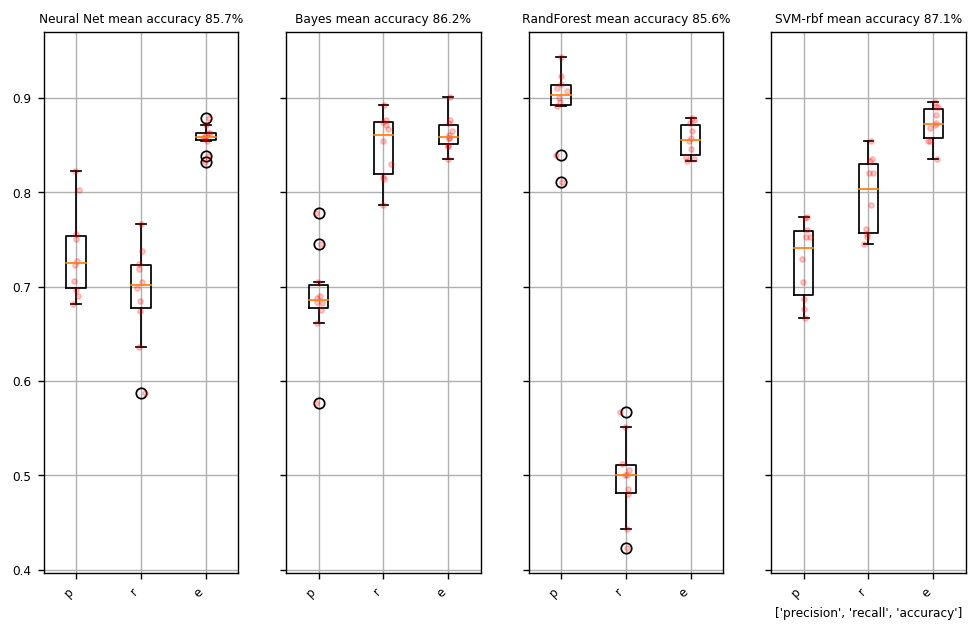

In [28]:
fig, axs = plt.subplots(1, len(models),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(models,  ['p','r','e'], fig, axs)
plt.xlabel(['precision', 'recall', 'accuracy'])
plt.show()

In [18]:
model_df = pd.DataFrame(models)
model_df.to_csv(f"Ar&Rev_models_relevance_{now}.csv",index=False) #removed doctables/ from dir

### We can choose the best performing model (for our purposes) and fit it on our unseen data, in order to predict the probability that our unseen documents are relevant

In [29]:
clf = SVC(kernel='rbf',class_weight='balanced',probability=True)

y = df['relevant']

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/indexes/range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


15967 out of 282414 documents are predicted to be relevant


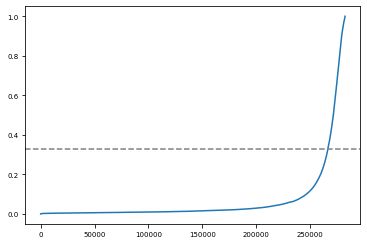

In [31]:
plt.close()

threshold = 0.33

df['0 - relevance - prediction'] = None
df.loc[unseen_index,'0 - relevance - prediction'] = y_pred[:,1]

predicted_index = df[df['0 - relevance - prediction']>threshold].index

fig, ax = plt.subplots()

pdf = df.sort_values('0 - relevance - prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['0 - relevance - prediction'])
ax.axhline(threshold,linestyle="--",color="grey")

rel = df[pdf['0 - relevance - prediction']>threshold].shape[0]
tot = pdf[pdf['0 - relevance - prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

df[['id','0 - relevance - prediction']].to_csv(f'predictions_{now}.csv',index=False)#removed doctables/ from dir

plt.show()

### Saving the outcome

In [109]:
#Added to write relevant docs to csv
#threshold = 0.33 # set if you didn't set it above
RelevantDocs  = df[(df['0 - relevance - prediction'] >= threshold) | (df['relevant'] == 1)]
RelevantDocs[['id', 'PY', 'title', 'content']].to_csv(f'{now}_Ar&REv_PredictedRelevantSVM.csv', index = False)

RelevantDocs.shape

(15728, 23)

In [110]:
#writing a smaller DF with just the IDs, human-made labels, and machine prediction
outdf = df[['id', 'relevant', 'seen', '0 - relevance - prediction']]
outdf.loc[outdf['seen'] ==0, 'relevant'] = None
outdf = outdf[['id', 'relevant', '0 - relevance - prediction']]
outdf.columns = ['id', 'label', 'prediction']

outdf.to_csv(f'IdLabelPrediction_{now}.csv', index=False)
outdf.head()

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,id,label,prediction
0,3487494,NaN,0.137359
1,3469235,NaN,0.0329321
2,3412530,NaN,0.0235021
3,3482141,NaN,0.0041195
4,3400113,NaN,0.0395413


In [ ]:
#create a new query that can be used for topic modelling for example
newq, created = Query.objects.get_or_create(
    project=p,
    creator=User.objects.get(username="eeajs@leeds.ac.uk"),
    title="The final run v2"
)

T = Doc.query.through
dqs = [T(doc_id=did, query=newq) for did in list(RelevantDocs['id'])]
T.objects.bulk_create(dqs)
newq.r_count = newq.doc_set.count()
newq.save()

In [ ]:
# Create a tag of positvely predicted so we can screen based on those if we want
tag, created = Tag.objects.get_or_create(
    title="positively predicted".format(now),
    query=q
)
tag.save()

for i, row in RelevantDocs.iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

### Evaluation of model

In [32]:
#SIMPLE EXAMPLE TO GET AN IDEA FOR HOW MUCH ADDED TRAINING DATA ADDS
#Requires re-training so will take a while
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#clf = SVC(kernel='rbf',class_weight='balanced',probability=True)

#y = df['relevant']

#WITH A RANDOM SAMPLE
scores = []
steps = np.linspace(0.05,1,10,endpoint=True)

#basically: take a random sample from the relevance column, use the index to create a matching sample from ab_x for different sizes
for n in steps:
    ysample = y[seen_index].sample(n=math.floor(y[seen_index].shape[0]*n))
    score = cross_val_score(clf,
                            ab_X[ysample.index],
                            ysample, 
                            cv=5,  scoring='f1')
    scores.append([len(ysample), score.mean(), score.std()*2])

scores

[[182, 0.0, 0.0],
 [566, 0.6179475918606353, 0.11949551685081776],
 [950, 0.7081581803030902, 0.1396121718320223],
 [1335, 0.7243714821763603, 0.06473857788978693],
 [1719, 0.7098519929321103, 0.02757115482645143],
 [2103, 0.7411267962611803, 0.03521074186725423],
 [2488, 0.7451168002884642, 0.011495977455316282],
 [2872, 0.7501256159593435, 0.04363709069566326],
 [3256, 0.7646086115002426, 0.038195337864363806],
 [3641, 0.7593833753383701, 0.024078278397352555]]

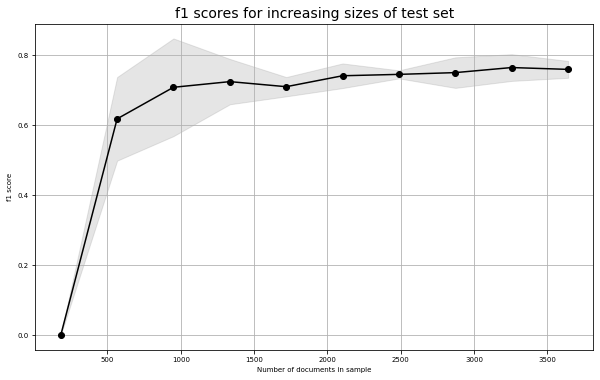

In [33]:
plt.close()
fig, ax = plt.subplots(figsize=(10,6))

xplot = [score[0] for score in scores]
yplot = [score[1] for score in scores]
yerr = [score[2] for score in scores]

ax.plot(xplot, yplot, 'k-o')

ax.fill_between(xplot,np.subtract(yplot,yerr), np.add(yplot, yerr),
                 color='gray', alpha=0.2)

ax.set_ylabel('f1 score')
ax.set_xlabel('Number of documents in sample')
ax.set_title('f1 scores for increasing sizes of test set', fontsize=14)
ax.grid()

plt.show()

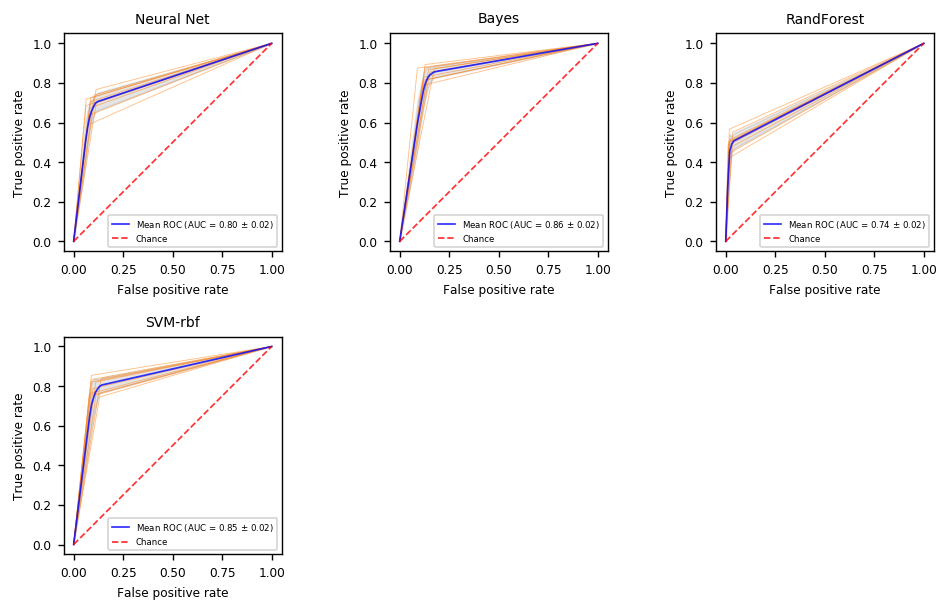

In [34]:
#Using the original k-fold crossvalidation: Area under curve plots
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for j, model in enumerate(models):
    ax = fig.add_subplot(2,3,j+1)
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = np.mean(model[f'auc'])
    std_auc = np.std(model[f'auc'])
    tprs = []
    for i in range(len(model['i'])):
        viz = ax.plot(
            model[f'fpr'][i],
            model[f'tpr'][i],
            lw=0.5,
            alpha=0.5,
            color=f"C1"
        )
        interp_tpr = interp(mean_fpr, model[f'fpr'][i], model[f'tpr'][i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    ax.plot(mean_fpr, mean_tpr, color='b',
    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
    lw=1, alpha=.8)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
        label='Chance', alpha=.8)

    ax.legend(fontsize=5)
    ax.set_aspect("equal")
    ax.set_title(model['title'],fontsize=8)
    ax.set_ylabel('True positive rate')
    ax.set_xlabel('False positive rate')
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    
        
fig.tight_layout()

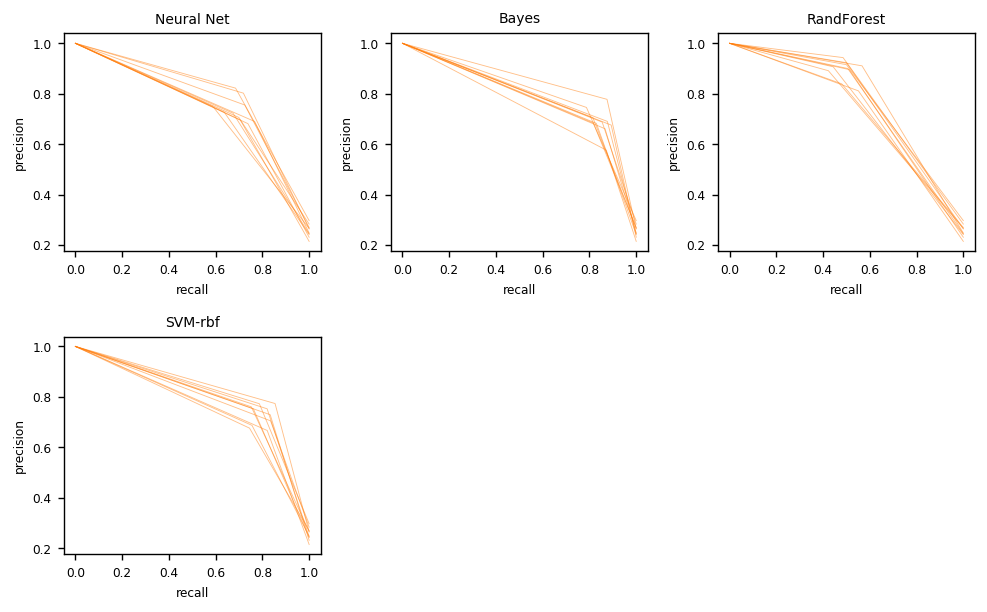

In [35]:
#Precission-recall plots 
from scipy import interp
fig = plt.figure(dpi=125, figsize=(8,5))
for j, model in enumerate(models):
    ax = fig.add_subplot(2,3,j+1)
    mean_fpr = np.linspace(0, 1, 100)
    mean_auc = np.mean(model[f'auc'])
    std_auc = np.std(model[f'auc'])
    tprs = []
    for i in range(len(model['i'])):
        viz = ax.plot(
            model[f'rec'][i],
            model[f'prec'][i],
            lw=0.5,
            alpha=0.5,
            color=f"C1"
        )
    ax.set_ylabel('precision')
    ax.set_xlabel('recall')
    ax.set_title(model['title'],fontsize=8)
        
fig.tight_layout()

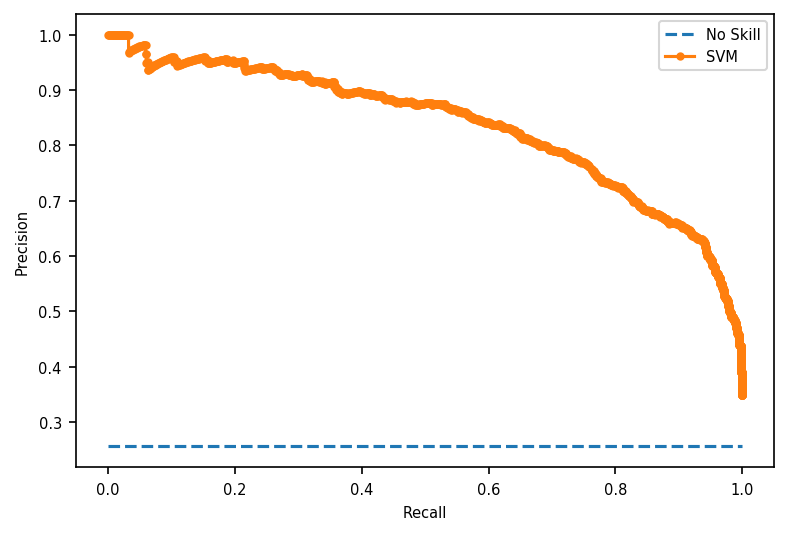

In [36]:
from sklearn.metrics import f1_score, auc

#predict probabilities
#lr_probs = clf.predict_proba(testX)
#r_probs = lr_probs[:, 1] #keep positive outcomes

fig, ax = plt.subplots(dpi=150)

lr_probs = df.loc[seen_index,'y_k_prediction']
lr_true = df.loc[seen_index,'relevant']

# predict class values
#yhat = clf.predict(testX)

# summarize scores
lr_precision, lr_recall, _ = lr_precision, lr_recall, thresholds = precision_recall_curve(lr_true, lr_probs)

#lr_f1, lr_auc = f1_score(lr_true, lr_probs), auc(lr_true, lr_probs)
#print('For sample: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(lr_true[lr_true==1]) / len(lr_true)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='SVM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show() 

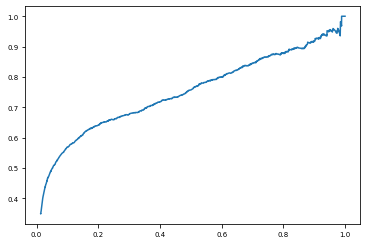

In [37]:
plt.plot(thresholds,lr_precision[:-1])

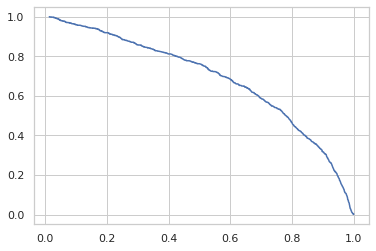

In [52]:
plt.plot(thresholds,lr_recall[:-1])

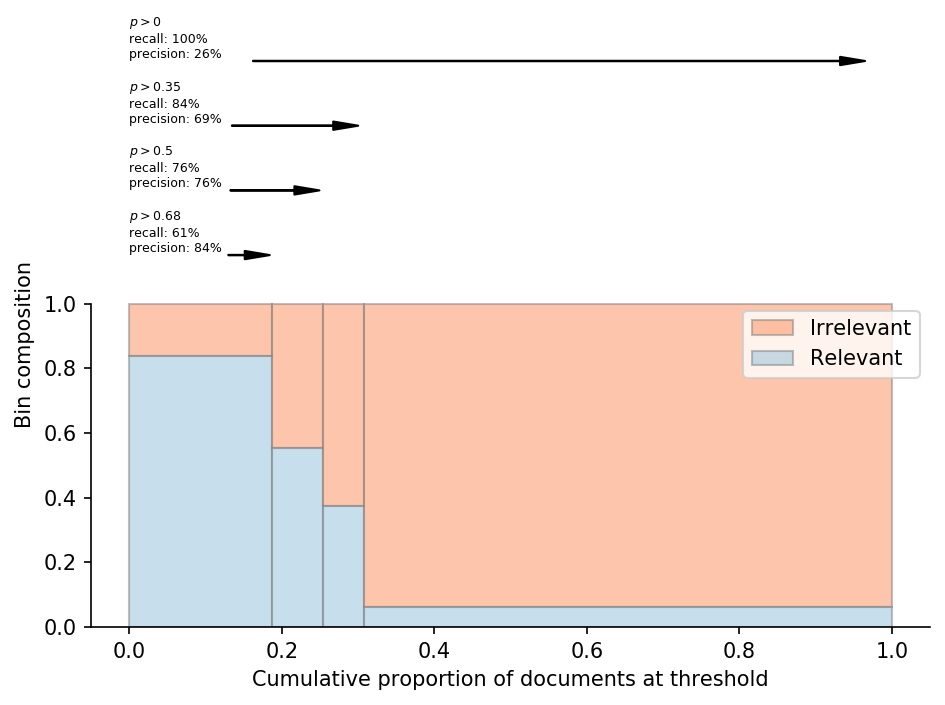

In [86]:
#If we want to play with the thresholds, we can use this function to see what the added/removed data looks like
import seaborn as sns

def precision_recall_bins(lr_true, lr_probs, bt):    
    fig, ax = plt.subplots(dpi=150)    
    categories = []
    
    for i in range(len(bt)-1):
        categories.append((bt[i+1],bt[i]))    
        
        l = 0
    for i,c in enumerate(categories):
        y_thresh_pred = np.where(lr_probs>c[0],1,0)
        y_bin_pred = np.where(np.logical_and(lr_probs<=c[1],lr_probs>c[0]),1,0)        
        
        bin_p = precision_score(lr_true,y_bin_pred)
        thresh_p = precision_score(lr_true,y_thresh_pred)   
        thresh_r = recall_score(lr_true,y_thresh_pred)           
        width = y_bin_pred.sum()/lr_true.shape[0]        
        
        if i==0:
            rl = "Relevant"
            il = "Irrelevant"
        else:
            rl=None
            il=None
            
        ax.bar(l, 1-bin_p,bottom=bin_p, width=width, align="edge",color="#fc8d59",ec="grey",alpha=0.5,label=il)
        ax.bar(l, bin_p, width=width, align="edge",color="#91bfdb",ec="grey",alpha=0.5,label=rl)        
        
        ly = 1.15+0.2*i        
        ax.annotate(
            f"$p>{c[0]}$ \nrecall: {thresh_r:.0%}\nprecision: {thresh_p:.0%}",
            (l+width,ly),(0,ly),
            arrowprops=dict(facecolor='black', shrink=0.04,width=0.2,headwidth=4),
            va="bottom", fontsize=6
        )
        
        l += width    
        
        sns.despine()    
        
        ax.spines['left'].set_bounds(0, 1)    
        
        ax.set_ylim(ymax=ly)
    ax.set_yticks([t for t in ax.get_yticks() if t <=1])
    ax.set_ylabel("Bin composition")
    ax.set_xlabel("Cumulative proportion of documents at threshold")    
    ax.legend(loc="right")    
    fig.tight_layout()
    
precision_recall_bins(lr_true, lr_probs, [1,0.68, 0.5, 0.35, 0]) #Start with 1, end with 0 so we see whole dataset

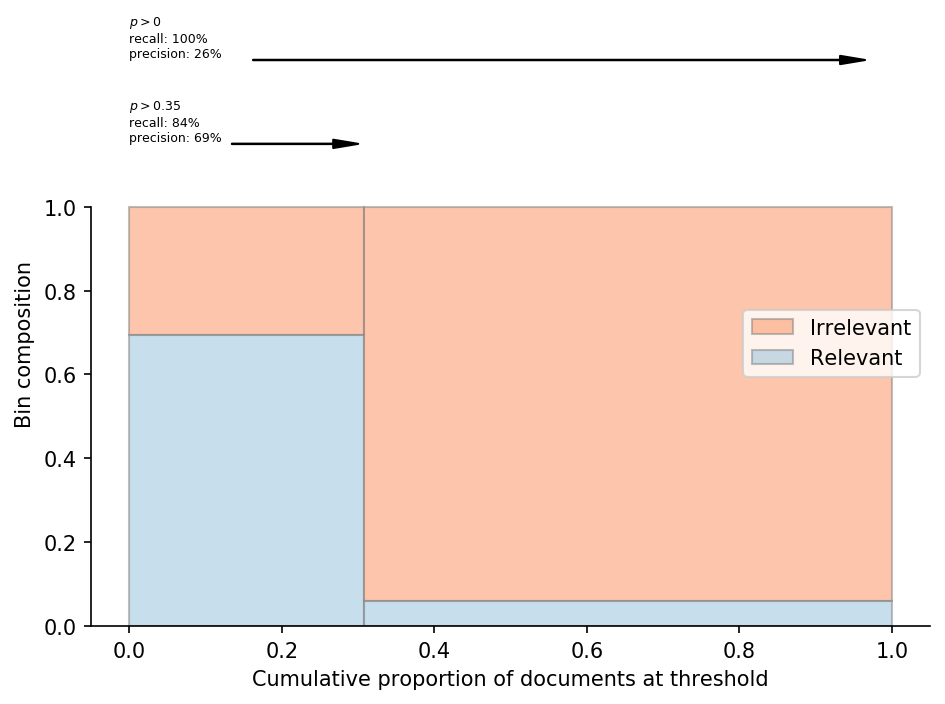

In [87]:
 precision_recall_bins(lr_true, lr_probs, [1,0.35, 0])

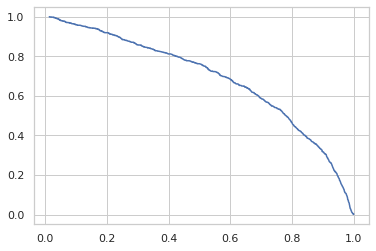

In [60]:
plt.plot(thresholds,lr_recall[:-1])

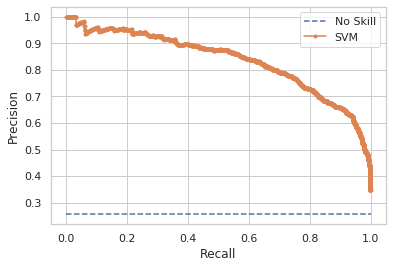

In [61]:
from sklearn.metrics import f1_score, auc

#predict probabilities
#lr_probs = clf.predict_proba(testX)
#r_probs = lr_probs[:, 1] #keep positive outcomes

lr_probs = df.loc[seen_index,'y_k_prediction']
lr_true = df.loc[seen_index,'relevant']

# predict class values
#yhat = clf.predict(testX)

# summarize scores
lr_precision, lr_recall, _ = lr_precision, lr_recall, thresholds = precision_recall_curve(lr_true, lr_probs)

#lr_f1, lr_auc = f1_score(lr_true, lr_probs), auc(lr_true, lr_probs)
#print('For sample: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

# plot the precision-recall curves
no_skill = len(lr_true[lr_true==1]) / len(lr_true)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='SVM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show() 

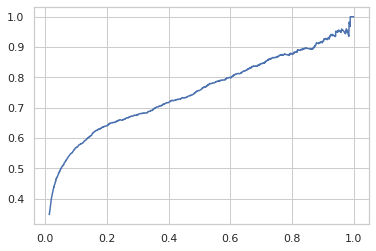

In [62]:
plt.plot(thresholds,lr_precision[:-1])

### Getting false positives/-negatives for a given threshold

In [63]:
#highest predicted
df.sort_values("y_k_prediction",ascending=False).head()

,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,1 - Adaptation,1 - Impact,1 - Mitigation,y_k_prediction,0 - relevance - prediction,categories,1 - Mitigation - k_prediction,1 - Mitigation - k_prediction_binary,1 - Adaptation - k_prediction,1 - Adaptation - k_prediction_binary,1 - Impact - k_prediction,1 - Impact - k_prediction_binary
77011,23858,Background: Bangladesh is one of the countries...,Knowledge and perception about climate change ...,2016.0,Climate change; Health; Knowledge; Perception;...,"[Public, Environmental & Occupational Health]",1.0,1.0,0.0,1.0,0.0,0.999993,None,1.0,0.005590,0.0,0.358464,0.0,0.900085,1.0
68515,1002682,Global climate change is anticipated to raise ...,Projecting future climate change impacts on he...,2018.0,Climate change; Heat-related mortality; Urban ...,"[Environmental Sciences; Public, Environmental...",1.0,1.0,0.0,1.0,0.0,0.999992,None,1.0,0.079722,0.0,0.057289,0.0,0.954213,1.0
239562,99183,Background: Bangladesh is facing the unavoidab...,Climate change and health in Bangladesh: a bas...,2016.0,climate change; health; adaptation; household;...,"[Public, Environmental & Occupational Health]",1.0,1.0,0.0,1.0,0.0,0.999981,None,1.0,0.008808,0.0,0.318379,0.0,0.939441,1.0
113711,564666,This study explored the impact of weather vari...,Weather factors influencing the occurrence of ...,2013.0,0,[Parasitology; Tropical Medicine],1.0,1.0,0.0,1.0,0.0,0.997332,None,1.0,0.001760,0.0,0.014812,0.0,0.995427,1.0
150026,3424027,The effects of exposure to air pollutants on h...,Exposure to NO2 and children hospitalization d...,2018.0,Air pollutants; Nitrogen dioxide; Particulate ...,"[Public, Environmental & Occupational Health]",1.0,1.0,0.0,1.0,0.0,0.997243,None,1.0,0.140585,0.0,0.005221,0.0,0.988550,1.0


In [66]:
#playing with the threshold (kind of irrelevant given additional analysis above, but easy reference)
threshold = 0.36
likely = np.where(df['y_k_prediction']>threshold,1,0)
p = precision_score(df.loc[seen_index,"relevant"],likely[seen_index])
r = recall_score(df.loc[seen_index,"relevant"],likely[seen_index])

print(f"Threshold: {threshold}, precision: {p:.2g}, recall: {r:.2g}")

Threshold: 0.36, precision: 0.7, recall: 0.83


In [67]:
#print false positives just above the border
#threshold = 0.33
fp = df[(df['relevant']==0) & (df[f'y_k_prediction']>threshold)]
print(fp.shape)
django.db.connection.close()
for i, row in fp.sort_values('y_k_prediction',ascending=True).head(3).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'])
    print(row['content'])
    print(row['id'])
    print(row['y_k_prediction'])
    print(d.docownership_set.filter(query=qid).values('user__username','relevant','finish','tag__title'))

(327, 20)

Landscape diversity and associated coping strategies during food shortage periods: evidence from the Sudano-Sahelian region of Burkina Faso
The importance of forest resources for rural communities' livelihoods has increasingly been recognized over the last three decades. Forests provide food, generate incomes, provide supporting (nutrient cycling, pollination), and regulating (climate, diseases, water regulation and purification) services for agriculture, in addition to their aesthetic, cultural and spiritual role. However, most of the studies on forest resource use do not focus on the role of landscape organization in addressing the impact of climate variability and the risk of food insecurity. This study aims to examine the contribution of woodlands and trees towards decreasing the risk of food insecurity and the importance of landscape structure and composition in coping with food shortages. It took place in two villages in Burkina Faso, on both ends of the woodlands and 

In [68]:
#False postives
fp = df[(df['relevant']==0) & (df[f'y_k_prediction']>0.5)]
print(fp.shape)
django.db.connection.close()

#print highest scoring ones
for i, row in fp.sort_values('y_k_prediction',ascending=False).head(3).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'])
    print(row['content'])
    print(row['id'])
    print(row['y_k_prediction'])
    print(d.docownership_set.filter(query=qid).values('user__username','relevant','finish','tag__title'))

(221, 20)

Climate change impacts on human health over Europe through its effect on air quality
This review examines the current literature on the effects of future emissions and climate change on particulate matter (PM) and O-3 air quality and on the consequent health impacts, with a focus on Europe. There is considerable literature on the effects of climate change on O-3 but fewer studies on the effects of climate change on PM concentrations. Under the latest Intergovernmental Panel on Climate Change (IPCC) 5th assessment report (AR5) Representative Concentration Pathways (RCPs), background O-3 entering Europe is expected to decrease under most scenarios due to higher water vapour concentrations in a warmer climate. However, under the extreme pathway RCP8.5 higher (more than double) methane (CH4) abundances lead to increases in background O-3 that offset the O-3 decrease due to climate change especially for the 2100 period. Regionally, in polluted areas with high levels of nitrogen o

In [69]:
#False negatives
fn = df[(df['relevant']==1) & (df[f'y_k_prediction']<0.5)]
print(fn.shape)
django.db.connection.close()
for i, row in fn.sort_values('y_k_prediction',ascending=True).head(3).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'])
    print(row['content'])
    print(row['id'])
    print(row['y_k_prediction'])
    print(d.docownership_set.filter(query=qid).values('user__username','relevant','finish','tag__title'))

(221, 20)

Genetic Improvement of Maize in India: Retrospect and Prospects
Maize (Zea mays L.) is the third most important crop of country after rice and wheat and is cultivated round the year. Its grain is used as feed, food and industrial raw material. Enormous progress has been made during last six decades to enhance yield potential through genetic improvement and alleviate effects due to various biotic-and abiotic-stresses. This review presents an overview of strategies followed in genetic improvement of maize and assesses their impact on productivity and production of the crop. A diverse range of indigenous and exotic germplasm and breeding material have been utilized. Breeding programme has been very vibrant and various strategies viz., composite breeding, double cross, three way cross and single-cross hybrid breeding have been adopted in cultivar development to enhance productivity across a range of production ecologies. Since 2000, more than 165 high-yielding cultivars of diffe

In [ ]:
#create a tag so I can check them out on the platform
tempq = merged_query #8510

tag, created = Tag.objects.get_or_create(
    title=f"false negatives{now}".format(now),
    query=tempq
)
tag.save()

for i, row in fn.sort_values('y_k_prediction',ascending=True).head(20).iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

In [92]:
tag, created = Tag.objects.get_or_create(
    title=f"false positives{now}".format(now),
    query=tempq
)
tag.save()

for i, row in fp.sort_values('y_k_prediction',ascending=False).head(20).iterrows():
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

# Now we want to look at impact, mitigation and adaptation

In [70]:
df['categories'] = df['1 - Mitigation'] + df['1 - Adaptation'] + df['1 - Impact']
print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("seen mitigation documents:", df.loc[df['seen']==1,'1 - Mitigation'].sum())
print("seen adaptation documents", df.loc[df['seen']==1,'1 - Adaptation'].sum())
print("seen impact documents", df.loc[df['seen']==1,'1 - Impact'].sum())
print("seen in multiple", df.loc[df['categories']>=2,].shape[0])
print("seen non-mit/ad documents",df.loc[(df['seen']==1) & (df['categories']==0),].shape[0])

seen documents: 3641
seen mitigation documents: 160.0
seen adaptation documents 198.0
seen impact documents 762.0
seen in multiple 128
seen non-mit/ad documents 2649


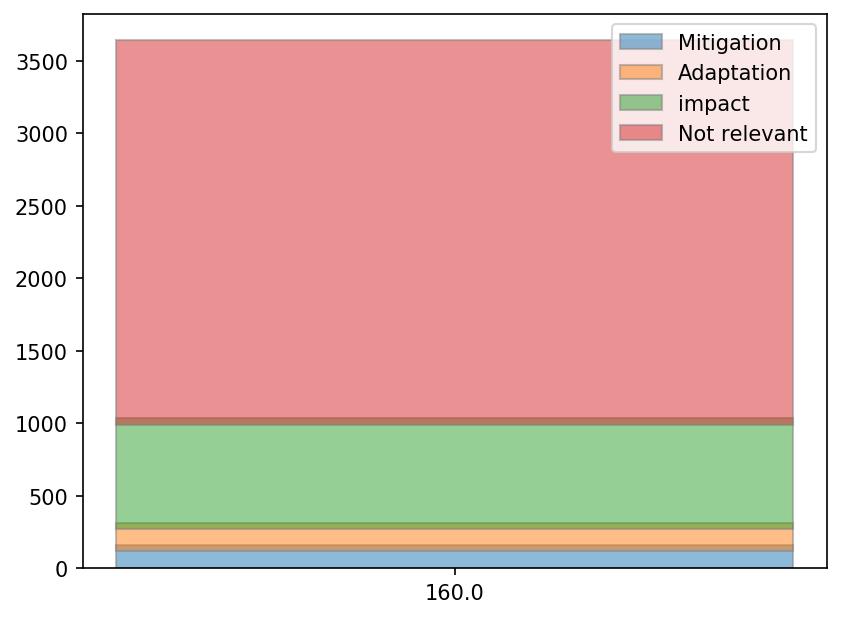

In [85]:
fig, ax = plt.subplots(dpi=150)

mitigation = df.loc[df['seen']==1,'1 - Mitigation'].sum()
adaptation = df.loc[df['seen']==1,'1 - Adaptation'].sum()
impact = df.loc[df['seen']==1,'1 - Impact'].sum()
overlap = df.loc[df['categories']>=2,].shape[0]
nonmitad = df.loc[(df['seen']==1) & (df['categories']==0),].shape[0]

lw = 1
alpha=0.5
ec = "grey"

ax.bar(
    0,mitigation,
    alpha=alpha, label="Mitigation",
    lw=lw, edgecolor=ec, tick_label = str(mitigation)
)
ax.bar(
    0,adaptation,bottom=mitigation-overlap/3,
    alpha=alpha, label="Adaptation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,impact,bottom=mitigation-2*overlap/3+adaptation ,
    alpha=alpha, label="impact",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,nonmitad,bottom=mitigation-overlap+adaptation+impact,
    alpha=alpha, label="Not relevant",
    lw=lw, edgecolor=ec,
)

ax.legend()

## We want to do multiclass prediction now

so we name the classes and create a matrix of class labels

In [72]:
classes = ["1 - Mitigation","1 - Adaptation", "1 - Impact"]
y = np.matrix(df[classes])
print(y.shape)

rel_index = df.loc[df["relevant"]==1,].index

(286144, 3)


and cross validate a model to see how well we can predict

In [47]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics, df = lu.cross_validate_models(ab_X, y, multimodels, rel_index, classes=classes, df=df)


1
2
3
4
5
6
7
8
9
10


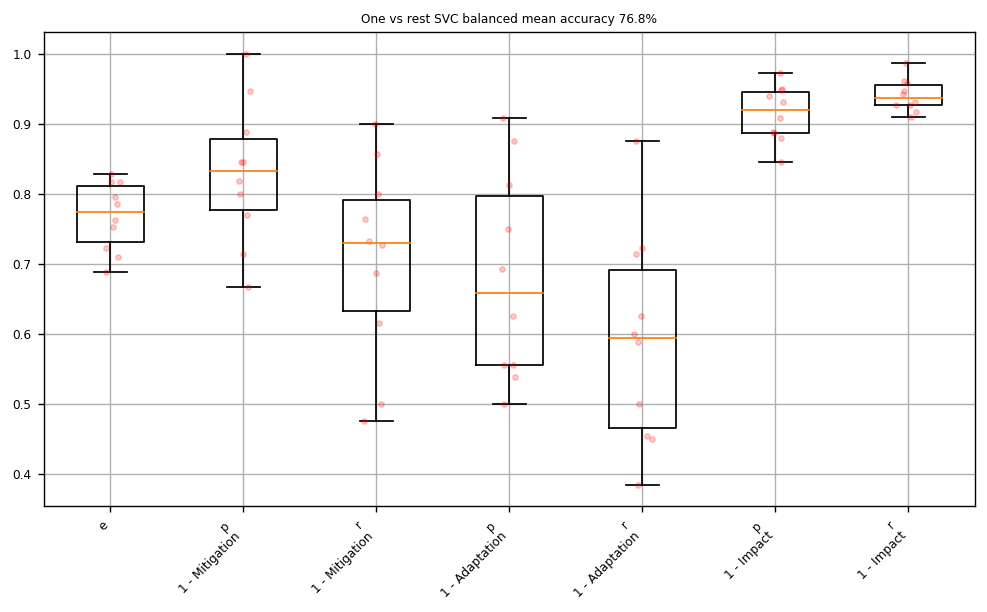

In [48]:
fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, [axs])
plt.show()

In [49]:
descriptives = [ #'e', 'p', 'r', 
                'e\n1 - Mitigation', 'p\n1 - Mitigation', 'r\n1 - Mitigation',
                'e\n1 - Adaptation', 'p\n1 - Adaptation', 'r\n1 - Adaptation',
                'r\n1 - Impact', 'p\n1 - Impact', 'r\n1 - Impact'
               ]
for des in descriptives:
    print(f'{des}  - {statistics.mean(multimodels[0][des])}')
    print(multimodels[0][des])
    print()

e
1 - Mitigation  - 0.9334134065431251
[0.925531914893617, 0.9354838709677419, 0.9247311827956989, 0.946236559139785, 0.956989247311828, 0.8494623655913979, 0.956989247311828, 0.967741935483871, 0.9032258064516129, 0.967741935483871]

p
1 - Mitigation  - 0.8296929970614181
[0.7142857142857143, 0.8461538461538461, 0.8461538461538461, 0.8, 0.9473684210526315, 0.7692307692307693, 1.0, 0.8888888888888888, 0.6666666666666666, 0.8181818181818182]

r
1 - Mitigation  - 0.7061529891676951
[0.5, 0.7333333333333333, 0.6875, 0.7272727272727273, 0.8571428571428571, 0.47619047619047616, 0.7647058823529411, 0.8, 0.6153846153846154, 0.9]

e
1 - Adaptation  - 0.8872683596431022
[0.8404255319148937, 0.956989247311828, 0.9139784946236559, 0.8924731182795699, 0.8602150537634409, 0.8924731182795699, 0.8602150537634409, 0.8709677419354839, 0.8709677419354839, 0.9139784946236559]

p
1 - Adaptation  - 0.6813471250971251
[0.6923076923076923, 0.875, 0.5, 0.9090909090909091, 0.5384615384615384, 0.555555555555555

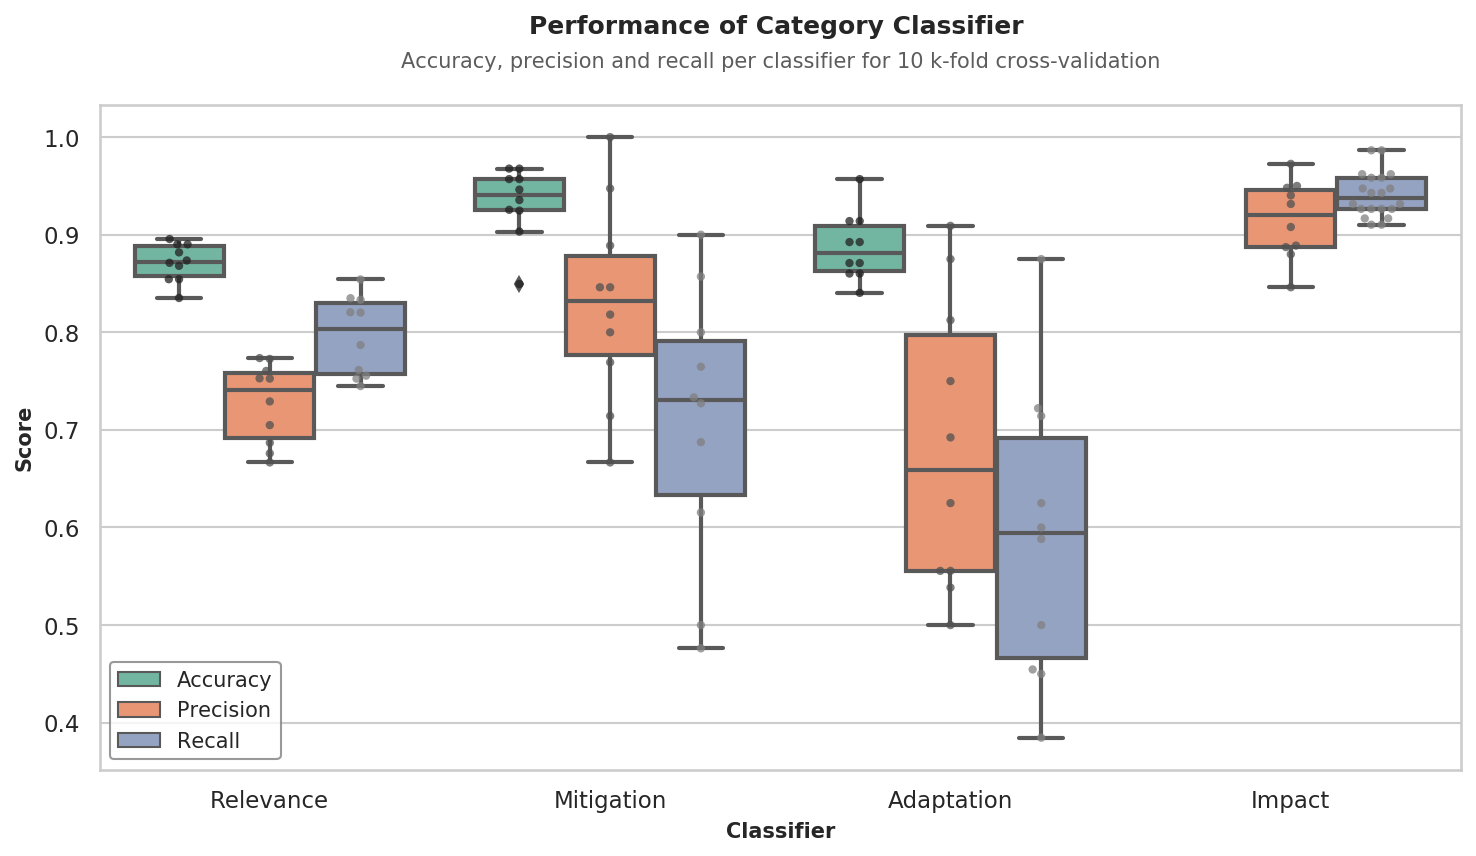

In [73]:
#With better formatting and the overall relevance included in one graph

boxplotdf = pd.DataFrame()
boxplotdf['Category'] = descriptives
gendf = pd.DataFrame({'Category' : ['e\n1 - Relevance', 'p\n1 - Relevance', 'r\n1 - Relevance']})

#get scores as list
boxplotdf['Scores'] = [multimodels[0][des] for des in boxplotdf['Category']]
gendf['Scores'] = [models[len(models)-1][des] for des in ['e', 'p', 'r']]

#merge the general and the multi-model
boxplotdf = pd.concat([gendf, boxplotdf], axis=0, ignore_index=True).reset_index()

#make a new row for each in list (basically: unfold the list to new variable, add new variable as column & drop old column)
s = boxplotdf.apply(lambda x: pd.Series(x['Scores']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Scores'
boxplotdf = boxplotdf.drop('Scores', axis=1).join(s)

#Get the category and the metric separately
new = boxplotdf["Category"].str.split("\n1 - ", n = 1, expand = True)
boxplotdf["Metric"]= new[0]
boxplotdf.drop(columns =["Category"], inplace = True) 
boxplotdf["Category"]= new[1] 

#rename
di = {'e': "Accuracy",
      'p': "Precision",
      'r': "Recall"}
boxplotdf.replace({"Metric": di}, inplace=True)

#plot 
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10,6),dpi=150)
ax = sns.boxplot(x="Category", y="Scores", hue="Metric",
                 data=boxplotdf, palette="Set2", linewidth = 2)

ax = sns.swarmplot(x="Category", y="Scores", hue="Metric", dodge=True, #add points
                   data=boxplotdf, color="grey", alpha = 0.75, size=4
                  ) 


ax.set_ylabel('Score', fontsize = 10, weight = 'bold')
ax.set_xlabel('Classifier', fontsize = 10, weight = 'bold')

title = 'Performance of Category Classifier '
subtitle = 'Accuracy, precision and recall per classifier for 10 k-fold cross-validation'
ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s=subtitle, fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
#l = plt.legend()
ax.legend(handles[0:3], labels[0:3],
          fontsize=10, title_fontsize='10', loc = 'lower left',
          facecolor = 'white', edgecolor='grey')


fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'{title}_{subtitle}.png')


In [79]:
for des in descriptives: 
    print(f'{des} - - {statistics.mean(multimodels[0][des])}')
    print()
    
print ('- - - - - ')
for des in ['e', 'p', 'r']:
    print(f'{des} - - {statistics.mean(multimodels[0][des])}')
    print()
    
statistics.mean(multimodels[0]['r\n1 - Impact'])

e
1 - Mitigation - - 0.9334134065431251

p
1 - Mitigation - - 0.8296929970614181

r
1 - Mitigation - - 0.7061529891676951

e
1 - Adaptation - - 0.8872683596431022

p
1 - Adaptation - - 0.6813471250971251

r
1 - Adaptation - - 0.5913904069786423

r
1 - Impact - - 0.9408441802894024

p
1 - Impact - - 0.9152721460102543

r
1 - Impact - - 0.9408441802894024

- - - - - 
e - - 0.7680393502630977

p - - 0.8736272197034055

r - - 0.8553955168667864



0.9408441802894024

In [80]:
boxplotdf = pd.DataFrame()
boxplotdf['Category'] = descriptives
gendf = pd.DataFrame({'Category' : ['e\n1 - Relevance', 'p\n1 - Relevance', 'r\n1 - Relevance']})

#get scores as list
boxplotdf['Scores'] = [multimodels[0][des] for des in boxplotdf['Category']]
gendf['Scores'] = [models[0][des] for des in ['e', 'p', 'r']]

#merge the general and the multi-model
boxplotdf = pd.concat([gendf, boxplotdf], axis=0, ignore_index = True)

#make a new row for each in list (basically: unfold the list to new variable, add new variable as column & drop old column)
s = boxplotdf.apply(lambda x: pd.Series(x['Scores']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'Scores'
boxplotdf = boxplotdf.drop('Scores', axis=1).join(s)

boxplotdf

,Category,Scores
0,e\n1 - Relevance,0.838356
0,e\n1 - Relevance,0.862637
0,e\n1 - Relevance,0.870879
0,e\n1 - Relevance,0.857143
0,e\n1 - Relevance,0.879121
...,...,...
11,r\n1 - Impact,0.942857
11,r\n1 - Impact,0.910256
11,r\n1 - Impact,0.947368
11,r\n1 - Impact,0.916667


In [81]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, ab_X[seen_index],y[seen_index], cv=5, scoring='recall_samples')

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/svm/_base.py", line 162, in fit
    accept_large_sparse=False)
  File "/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/utils/validation.py", line 73, in inner_f
    return f(**kwargs)
  File "/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/utils/v

array([nan, nan, nan, nan, nan])

## Multi-matrix

['1 - Mitigation - k_prediction_binary', '1 - Adaptation - k_prediction_binary', '1 - Impact - k_prediction_binary']


<bound method Figure.show of <Figure size 1000x1000 with 2 Axes>>

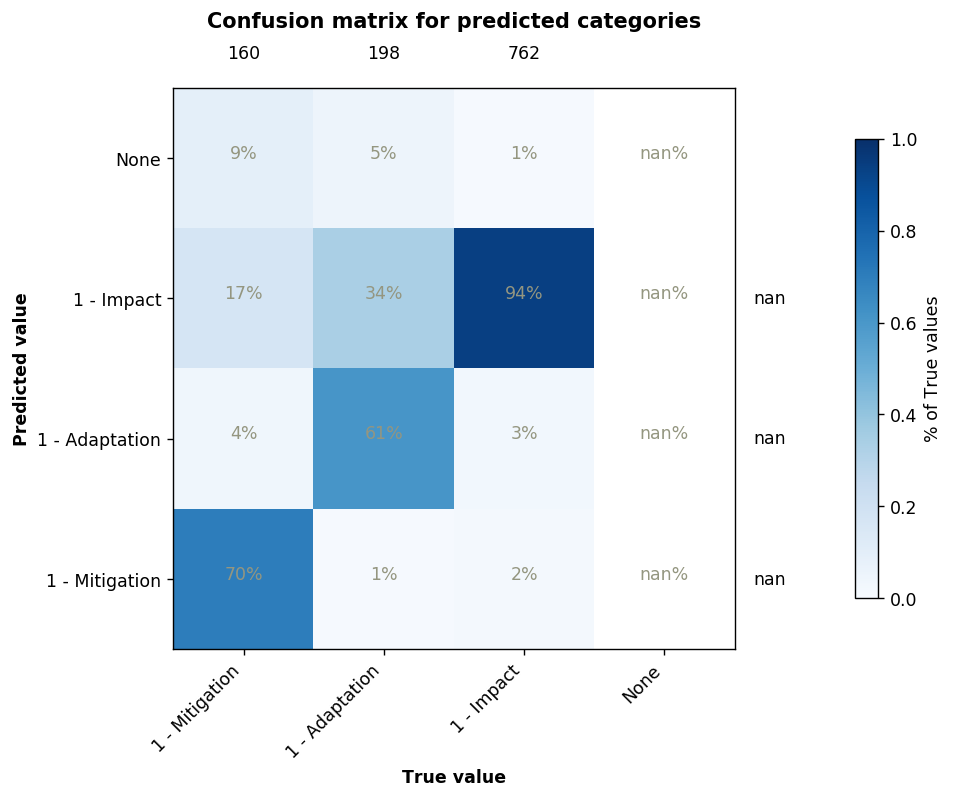

In [84]:
import seaborn as sns
sns.reset_defaults()
classes = ["1 - Mitigation","1 - Adaptation", "1 - Impact"]
cols = [f"{c} - k_prediction_binary" for c in classes]
print(cols)
y_pred = np.array(list(df.loc[seen_index,cols].values))
   
y_true = y[seen_index]

confusion_matrix = np.zeros(shape=(len(classes)+1,len(classes)+1),dtype=float)

norm = True

for j, c in enumerate(classes): #rows
    for k, c in enumerate(classes): #cols
        n = 0
        for i in range(len(seen_index)):
            if j==k:
                if y_true[i,j]+y_pred[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1/y_pred[i,].sum()
        confusion_matrix[j,k]=n
        
    sums_pred = y_pred.sum(axis=1).ravel()
    confusion_matrix[k+1,j]=y_true[np.argwhere(sums_pred==0).ravel(),j].sum()
    sums_true = y_true.sum(axis=1).ravel()
    confusion_matrix[j,k+1]=y_pred[np.argwhere(sums_true==0).ravel(),j].sum()
    confusion_matrix[j+1,k+1] = y_pred[np.argwhere(sums_true+sums_pred==0)].shape[0]


if norm is not False:
    confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0,keepdims=True)


fig, ax = plt.subplots(dpi=125, figsize=(8,8))


if norm is not False:
    mat = ax.imshow(confusion_matrix, cmap="Blues", vmin=0, vmax=1, origin="lower")
else:
    mat = ax.imshow(confusion_matrix, cmap="Blues",origin="lower")
    
classes = classes + ["None"]
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > np.max(confusion_matrix)/2:
            color="#d9d9d9"
        else:
            color="#949680"
        if norm is not False:
            ax.text(k,j, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        else:
            ax.text(k,j, f"{confusion_matrix[j,k]:.1f}",ha="center",color=color)

    if j < len(classes)-1:    
        ax.text(j,len(classes)-0.25,f"{y_true[:,j].sum():,.0f}",ha="center",va="center")
        ax.text(len(classes)-0.25, j, f"{y_pred[:,j].sum():,.0f}",ha="center",va="center")
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_xlabel("True value", fontsize = 10, weight = 'bold')
ax.set_ylabel("Predicted value", fontsize = 10, weight = 'bold')

#ax.set_xlim(xmax=len(classes)+1)

cbar = fig.colorbar(mat, ax=ax, pad=0.15, shrink = 0.5)
if norm is not False:
    cbar.set_label("% of True values")
    
title = "Confusion matrix for predicted categories"
ax.text(x=0.5, y=1.1, s=title, fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(f'confusion_matrix.png')
fig.show

In [101]:
model_df = pd.DataFrame(multimodels)
#model_df.to_csv(f"multimodels_adaptation_mitigation_{now}.csv",index=False)

### Fitting multi-class

In [126]:
predicted_index = df[df['0 - relevance - prediction']>0.33].index
LabeledRelevant_index = df[df['relevant']==1].index

clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
classes = ["1 - Mitigation","1 - Adaptation", "1 - Impact"]
y = np.matrix(df[classes])
y.shape

clf.fit(ab_X[seen_index],y[seen_index]) #fit on the labeled as relevant data
predictions = clf.predict_proba(ab_X[predicted_index]) #get probability scores for those predicted to be relevant
binary = clf.predict(ab_X[predicted_index]) #get binary scores too

In [128]:
#Add predictions to the dataframe or nan if no prediction
for i,c in enumerate(classes):
    df[f"{c} - prediction"] = np.NaN
    
    df.loc[predicted_index, f"{c} - prediction"] = predictions[:, i]

In [129]:
#Check
print(df[df['1 - Adaptation - prediction'] > .1].shape)
df[df['1 - Adaptation - prediction'] > .1].head(20)

(3281, 23)


,id,content,title,PY,wosarticle__de,wosarticle__wc,relevant,seen,1 - Adaptation,1 - Impact,...,categories,1 - Mitigation - k_prediction,1 - Mitigation - k_prediction_binary,1 - Adaptation - k_prediction,1 - Adaptation - k_prediction_binary,1 - Impact - k_prediction,1 - Impact - k_prediction_binary,1 - Mitigation - prediction,1 - Adaptation - prediction,1 - Impact - prediction
23,229038,Objective: Climate change is expected to cause...,Forecasted Impact of Climate Change on Infecti...,2016.0,infectious disease medicine; emergency prepare...,"[Public, Environmental & Occupational Health]",0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.002406,0.200001,0.608046
31,119515,Water is recognized to pose some very urgent q...,Water and justice: Towards an ethics of water ...,2013.0,0,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.029100,0.106526,0.260609
122,3479297,Objective:Individuals exposed to natural disas...,Challenges Faced and Support Received: Older A...,2017.0,Hurricane Sandy; older adults; qualitative; di...,"[Public, Environmental & Occupational Health]",0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.007990,0.585607,0.239867
130,3473785,A rapid review of literature was conducted to ...,Evidence for the value of health promotion int...,2017.0,health-promoting environments; evidence; globa...,"[Health Policy & Services; Public, Environment...",0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.004042,0.350849,0.137286
150,3369215,Objectives: Older adults exposed to natural di...,"Exposure to Hurricane Sandy, neighborhood coll...",2017.0,PTSD; Hurricane Sandy; older adults; collectiv...,[Geriatrics & Gerontology; Gerontology; Psychi...,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.007627,0.198261,0.702334
171,1282303,Small-scale farmers are highly threatened by c...,Risk perception and decision-making: do farmer...,2018.0,0,[Environmental Sciences; Meteorology & Atmosph...,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.006769,0.912043,0.092545
300,1622298,This study analyzed the vulnerability to flood...,Spatial Analysis of Vulnerability to Flooding ...,2015.0,vulnerability; flooding; Port Harcourt; Nigeria,"[Social Sciences, Interdisciplinary]",0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.020289,0.145293,0.544039
505,3311260,Latina immigrant women in the U.S. are at incr...,"""Se vale llorar y se vale reir"": Latina Immigr...",2020.0,Latina; Immigrant; Migration; Mental health; S...,"[Public, Environmental & Occupational Health]",0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.008080,0.287744,0.265694
515,144497,Background: Leptospirosis is a globally import...,"Knowledge, perceptions, and environmental risk...",2014.0,"Leptospirosis; KAP (knowledge, attitude, perce...","[Public, Environmental & Occupational Health; ...",0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.041718,0.243867,0.515445
603,3313547,The authors of this article interviewed reside...,Perceptions of air pollution by the inhabitant...,2019.0,air pollution; perceptions; urban health; Came...,"[Public, Environmental & Occupational Health]",0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.155351,0.363665,0.262606


### False positives & Negatives
First, let's look into the high number of adaptation docs being classified as impact

In [130]:
#Just because I got tired of getting the titles confused, import markdown display
from IPython.display import Markdown, display
def printmd(string): 
    display(Markdown(string))
    
confusion = df[
   (df['1 - Adaptation'] == 1) 
   & (df['1 - Adaptation - k_prediction_binary'] == 0) 
   & (df['1 - Impact - k_prediction_binary'] == 1)
    ]

for i, row in confusion.sort_values('1 - Impact - k_prediction',ascending=False).head(5).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    printmd(f"**{row['title']}**")
    print(row['content'])
    #print(row['id'])
    printmd(f"*Impact prediction: {row['1 - Impact - k_prediction']} -- Adaptation prediction: {row['1 - Adaptation - k_prediction']}*" )
    #print(d.docownership_set.filter(query=qid).values('user__username','relevant','finish','tag__title'))

**Exploring the role of forest resources in reducing community vulnerability to the heat effects of climate change**

While the growing literature on forest ecosystem services has examined the value and significance of a range of services, our understanding of the health-related benefits of ecosystem services from forests is still limited. To characterize the role of forest resources in reducing community vulnerability to the heat effects of climate change, a general index of heat vulnerability (HEVI) was developed through Principle Components Analysis (PCA) and subsequently used within ANVOA and Poisson regression to assess the relationship between the amount and type of forest resources (species, management regime, spatial pattern) and a county's vulnerability to the heat effects of climate change. Results of the ANOVA showed significant differences in the extent and characteristics of forests among counties experiencing different levels of heat vulnerability. The Poisson regression using county heat mortality as the dependent variable found forest characteristics to have a significant influence on 

*Impact prediction: 0.988821596232408 -- Adaptation prediction: 0.40813219661968386*

**Modification of Heat-Related Mortality in an Elderly Urban Population by Vegetation (Urban Green) and Proximity to Water (Urban Blue): Evidence from Lisbon, Portugal**

BACKGROUND: Urban populations are highly vulnerable to the adverse effects of heat, with heat-related mortality showing intra-urban variations that are likely due to differences in urban characteristics and socioeconomic status. OBJECTIVES: We investigated the influence of urban green and urban blue, that is, urban vegetation and water bodies, on heat-related excess mortality in the elderly >65 years old in Lisbon, Portugal, between 1998 and 2008. METHODS: We used remotely sensed data and geographic information to determine the amount of urban vegetation and the distance to bodies of water (the Atlantic Ocean and the Tagus Estuary). Poisson generalized additive models were fitted, allowing for the interaction between equivalent temperature [universal thermal climate index (UTCI)] and quartiles of urban greenness [classified using the Normalized Difference Vegetation Index (NDVI)] and proximity to water (<= 4 km vs. >4 km), while adjusting for potential confounders. RESULTS: The associa

*Impact prediction: 0.9876950006044775 -- Adaptation prediction: 0.04418344431726213*

**Analysis of clinical malaria disease patterns and trends in Vietnam 2009-2015**

Background: Viet Nam has made tremendous progress towards reducing mortality and morbidity associated with malaria in recent years. Despite the success in malaria control, there has been a recent increase in cases in some provinces. In order to understand the changing malaria dynamics in Viet Nam and measure progress towards elimination, the aim of this study was to describe and quantify spatial and temporal trends of malaria by species at district level across the country. Methods: Malaria case reports at the Viet Nam National Institute of Malariology, Parasitology, and Entomology were reviewed for the period of January 2009 to December 2015. The population of each district was obtained from the Population and Housing Census-2009. A multivariate (insecticide-treated mosquito nets [ITN], indoor residual spraying [IRS], maximum temperature), zero-inflated, Poisson regression model was developed with spatial and spatiotemporal random effects modelled using a conditional autoregressive pr

*Impact prediction: 0.9876447495044232 -- Adaptation prediction: 0.014866312973916926*

**Baseline drivers of lymphatic filariasis in Burkina Faso**

Lymphatic filariasis (LF) is a parasitic disease that is endemic throughout sub-Saharan Africa, infecting approximately 40 million people. In Burkina Faso, mass drug administration (MDA) for LF with ivermectin and albendazole has been ongoing since 2001, and by 2006 all endemic health districts were receiving MDA with a therapeutic coverage of at least 65%. As MDA activities scale down, the focus is now on targeting areas where LF transmission persists with alternative elimination strategies. This study explored the relationship between village-level, baseline LF prevalence data collected in 2000 with publicly available meteorological, environmental and demographic variables in order to determine the factors that influence the geographical distribution of the disease. A fitted multiple logistic regression model indicated that the length of the rainy season, variability in normalized difference vegetation index (NDVI) and population density were significantly positively associated with 

*Impact prediction: 0.9837931562793839 -- Adaptation prediction: 0.10562732946485374*

**The current status of malaria epidemiology in Bolifamba, atypical Cameroonian rainforest zone: an assessment of intervention strategies and seasonal variations**

Background: Global malaria has been on the decline over the past decade due to expansion of interventions. The present study aimed at determining the current status of malaria epidemiology in the context of sustained interventions and seasonal variations in Bolifamba, which represents a typical semi-urban malaria endemic community in the Cameroonian rainforest. Methods: A monthly cross-sectional survey was carried out in Bolifamba, a multi ethnic semi-urban locality on the eastern flanks of Mt Cameroon, for a year during which blood samples were collected from participants and examined for malaria parasites by microscopy. Correlation analysis of seasonal/monthly malaria prevalence was done with weather data from Ekona, a nearby village with a meteorological station. Intervention strategy such as use of Insecticide Treated Bed Net (ITBN) and risk factors such as duration of stay in the locality, age and housing type were also investigated. Results: The results revealed a malaria prevale

*Impact prediction: 0.9830870103744226 -- Adaptation prediction: 0.0216149466006877*

In [131]:
#Listing all false positives and false negatives
#NB: this includes docs belonging to multiple classes where only one was classified wrongly
classes_pred = [(c, c+" - k_prediction_binary") for c in classes[0:-1]]

c_fp = pd.DataFrame(columns = df.columns)
c_fn = pd.DataFrame(columns = df.columns)

for c, c_p in classes_pred:
    c_fn = c_fn.append(df[(df[c]==1) & (df[c_p]==0)])
    c_fp = c_fp.append(df[(df[c]==0) & (df[c_p]==1)])
    
print(f"False negatives: {c_fn.shape[0]} \nFalse positives: {c_fp.shape[0]}")

False negatives: 108 
False positives: 59


In [132]:
df['categories'] = df['1 - Mitigation'] + df['1 - Adaptation'] + df['1 - Impact']
print(f"Total categorised: {df.loc[df['categories']>=1].shape[0]}")

Total categorised: 1035


In [94]:
#create a tag so I can check them out on the platform
tempq = merged_query

tag, created = Tag.objects.get_or_create(
    title=f"Categories f neg {now}".format(now),
    query=tempq
)
tag.save()

for i, row in c_fn.iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

In [ ]:
#same for false positives
tag, created = Tag.objects.get_or_create(
    title=f"Categories f pos {now}".format(now),
    query=tempq
)
tag.save()

for i, row in c_fp.iterrows(): #using the index of the newly created dataframe on the full df
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(tag)
tag.update_tag()

#### To CSV

In [133]:
columns = ['1 - Adaptation', '1 - Mitigation', '1 - Impact' ]
ycols = [col + ' - k_prediction' for col in columns]
pcols = [col + ' - prediction' for col in columns]
outdf = df[['id', 'relevant', 'seen']]
outdf[ycols] = df[ycols]
outdf[pcols] = df[pcols]
outdf.head()

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,id,relevant,seen,1 - Adaptation - k_prediction,1 - Mitigation - k_prediction,1 - Impact - k_prediction,1 - Adaptation - prediction,1 - Mitigation - prediction,1 - Impact - prediction
0,3487494,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3469235,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3412530,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3482141,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3400113,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
#writing a smaller DF with just the IDs, human-made labels, and machine prediction
#outdf = df[['id', 'relevant', 'seen', '0 - relevance - prediction']]
outdf.loc[outdf['seen'] ==0, 'relevant'] = None
for n, ycol in enumerate(ycols):
    outdf[ycol] = np.where(outdf['seen'] == 1, outdf[ycol], outdf[pcols[n]])
       
outdf = outdf.rename(columns={
    'relevant': 'label',
    '1 - Impact - k_prediction': 'impact',
    '1 - Adaptation - k_prediction': 'adaptation',
    '1 - Mitigation - k_prediction': 'mitigation'
})

outdf = outdf[['id', 'label', 'adaptation', 'mitigation', 'impact']].dropna(thresh=5)

outdf.to_csv(f'IdCategoryPrediction.csv', index=False)
outdf.head()

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,label,adaptation,mitigation,impact
1196,3444052,1.0,0.645582,0.007951,0.734522
1289,372560,1.0,0.009631,0.992552,0.027864
1354,3412436,1.0,0.009262,0.006185,0.995459
1440,780148,1.0,0.007368,0.017563,0.992867
1530,610777,1.0,0.196543,0.049694,0.721092


In [95]:
outdf.shape

(16229, 5)

In [96]:
outdf.to_csv(f'IdCategoryPrediction.csv', index=False)
outdf.shape

(16229, 5)

In [218]:
outdf[outdf['mitigation'] == 1].shape

(609, 5)